

# A simple finite-difference solver
An intro to our loss module's finite difference utility demonstrating
its use to create a simple numerical solver for the diffusion-advection equation.


## Import the library
We first import our `neuralop` library and required dependencies.



In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from neuralop.losses.finite_diff import central_diff_2d  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Defining our problem
We aim to solve the 2D diffusion advection equation:

$u_t + cx \cdot u_x + cy \cdot u_y = \nu (u_xx + u_yy) + f(x,y,t)$,

Where $f(x,y,t)$ is a source term and $cx$ and $cy$ are advection speeds in x and y.
We set simulation parameters below:



In [2]:
## Simulation parameters
Lx, Ly = 2.0, 2.0   # Domain lengths
nx, ny = 64, 64   # Grid resolution
T = 1.6    # Total simulation time
dt = 0.001  # Time step
nu = 0.02   # diffusion coefficient
cx, cy = 1.0, 0.6  # advection speeds

## Create grid
X = torch.linspace(0, Lx, nx, device=device).repeat(ny, 1).T 
Y = torch.linspace(0, Ly, ny, device=device).repeat(nx, 1)  
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
nt = int(T / dt)


## Initial condition and source term
u = (-torch.sin(2 * np.pi * Y) * torch.cos(2 * np.pi * X)
        + 0.3 * torch.exp(-((X - 0.75)**2 + (Y - 0.5)**2) / 0.02)
        - 0.3 * torch.exp(-((X - 1.25)**2 + (Y - 1.5)**2) / 0.02)).to(device)

def source_term(X, Y, t):
    return 0.2 * torch.sin(3 * np.pi * X) * torch.cos(3 * np.pi * Y) * torch.cos(4 * np.pi * t)

## Simulate evolution using numerical solver



In [3]:
u_evolution = [u.clone()]

t = torch.tensor(0.0)
for _ in range(nt):
    
    # Compute derivatives
    u_x, u_y = central_diff_2d(u, [dx, dy])
    u_xx, _ = central_diff_2d(u_x, [dx, dy])
    _, u_yy = central_diff_2d(u_y, [dx, dy])

    # Evolve one step in time using Euler's method
    u = u + dt * (-cx * u_x - cy * u_y + nu * (u_xx + u_yy) + source_term(X, Y, t))
    t += dt
    u_evolution.append(u.clone())

u_evolution = torch.stack(u_evolution).cpu().numpy()

## Animate our solution



MovieWriter Pillow unavailable; using Pillow instead.


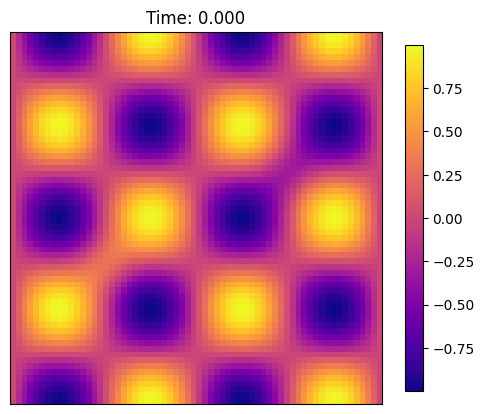

In [4]:
num_frames = 100
frame_indices = torch.linspace(0, len(u_evolution) - 1, num_frames, dtype=torch.int).cpu().numpy()
u_frames = u_evolution[frame_indices]

fig, ax = plt.subplots(figsize=(6, 6))
cmap_u = ax.imshow(u_frames[0], extent=[0, Lx, 0, Ly], origin="lower", cmap="plasma")
ax.set_title("Advection-Diffusion: u")
plt.colorbar(cmap_u, ax=ax, shrink=0.75)

def update(frame):
    cmap_u.set_data(u_frames[frame])
    ax.set_title(f"Time: {frame_indices[frame] * dt:.3f}")
    ax.set_xticks([])
    ax.set_yticks([])
    return cmap_u,

ani = animation.FuncAnimation(fig, update, frames=len(u_frames), interval=50, blit=False)
ani.save("advection_diffusion.gif", writer="Pillow", fps=30)